In [1]:
import wrapper as wp
import pandas as pd
import os
from itertools import product
import plotly.express as px

df = pd.read_csv("Feature_Matrix_delta_AR24.csv")

In [30]:
priolist = ['model_lag12_scalerStandard_lead1_profileall_features_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profilecontrols_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profileBM_composite_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profileBM_poormans_typelinear.pkl',
'model_lag6_scalerStandard_lead1_profilenarratives_ID_only_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profileBM_composite_net_only_typelinear.pkl',
'model_lag6_scalerStandard_lead1_profilenarratives_net_only_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profilenarratives_net_only_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profilenarratives_ID_only_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profileBM_composite_typelassocv.pkl',
'model_lag12_scalerStandard_lead1_profileall_features_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profilecontrols_typelassocv.pkl']

## Run models on the whole sample

-> Now saving model_lag6_scalerStandard_lead1_profileBM_poormans_typelinear.pkl
✅ No columns dropped by variance thresholding.
Number of Non-zero coefficients: 5
Test MSE: 0.000004
Non-zero coefficients:
delta_log_cpi_next_month_lag1    0.002560
delta_log_cpi_next_month_lag2   -0.000914
delta_log_cpi_next_month_lag5   -0.000374
delta_log_cpi_next_month_lag4    0.000240
delta_log_cpi_next_month_lag3   -0.000024
dtype: float64

Last train date: 2023-03-01 00:00:00 self.testsize: 0.012
BM_poormans linear model fitted from 2001-05-01 to 2025-02-01 with lag = 5 months and lead = 1 months.
Model saved to run_1807/model_lag6_scalerStandard_lead1_profileBM_poormans_typelinear.pkl.
-> Now saving model_lag6_scalerStandard_lead1_profilecontrols_typelassocv.pkl
✅ No columns dropped by variance thresholding.
Number of Non-zero coefficients: 2
Optimal alpha: 0.0005933717538503723
Test MSE: 0.000001
Non-zero coefficients:
delta_log_cpi_next_month_lag1    0.001484
GSCI_Cotton_lag0                 0.00

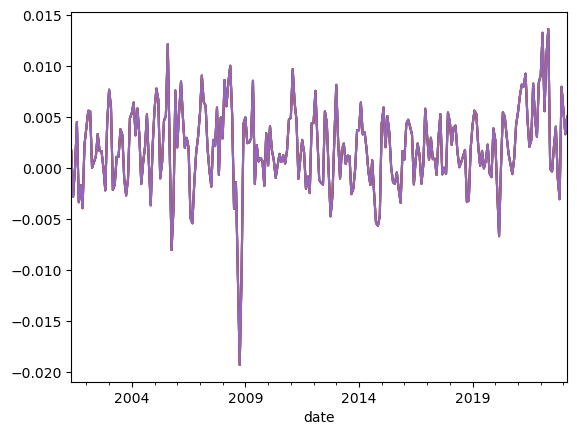

In [31]:
# Define the parameter grid
max_lags = [1, 3, 6, 12]
scalers = ["Standard", "zca"]
leads = [1]#[1, 3, 6]
profiles = ["BM_poormans",
    "narratives_and_composite", "controls", "narratives", "narratives_net_only",
    "narratives_ID_only", "BM_composite", "BM_composite_net_only", "all_features"
]
modeltypes = ["linear", "lassocv", "elasticnetcv"]

# Create output directory
output_dir = 'run_1807'
os.makedirs(output_dir, exist_ok=True)

# Loop through all combinations
for lag, scaler, lead, profile, modeltype in product(max_lags, scalers, leads, profiles, modeltypes):
    model = wp.Model(df)
    #model.auto_print = False
    model.testsize = 0.012
    model.window = 286
    model.set_maxlag(lag)
    model.scaler = scaler
    model.lead = lead
    model.set_profile(profile)
    model.set_modeltype(modeltype)

    # Generate filename based on parameters
    filename = f"model_lag{lag}_scaler{scaler}_lead{lead}_profile{profile}_type{modeltype}.pkl"
    filepath = os.path.join(output_dir, filename)

    # Run and save the model
    if not (scaler=='zca' and profile=='BM_poormans') and filename in priolist:
        print(f"-> Now saving {filename}")
        model.run_model(save_to_dir=[output_dir, filename])


## Evaluate Models

In [ ]:
import glob
import joblib
from single_model_test import EvaluationSingleModel
# Find all .pkl files in the models/ subfolder
subfolder = "run_1807"
pkl_files = glob.glob(subfolder+"/*.pkl")

rmse_dfs = []
model_names = []

for pkl_file in pkl_files:
    model_name = pkl_file.split("/")[-1].replace(".pkl", "")
    print(f"Processing : {pkl_file}")
    print(joblib.load(pkl_file))
    model = EvaluationSingleModel(model_dict=joblib.load(pkl_file), df=df, mute = True)
    rmse_df = model.rolling_forward_rmse(window_size=12)
    rmse_df = rmse_df.rename(columns={"rmse": model_name})
    # Ensure start_date is in datetime format with dayfirst=True
    rmse_df["start_date"] = pd.to_datetime(rmse_df["start_date"], dayfirst=True)
    rmse_dfs.append(rmse_df.set_index("start_date"))
    model_names.append(model_name)

# Join all rmse_dfs on start_date
rmse_all = pd.concat(rmse_dfs, axis=1).reset_index()
print(rmse_all['start_date'].iloc[0])
#rmse_all.to_csv("run_1507/all_models_rmse.csv")
print(f'Number of models computed: {len(rmse_all.columns)}')
fig = px.line(rmse_all, x="start_date", y=rmse_all.columns, title="12-Month Forward RMSE Over Time for Non-Linear Models")
fig.update_yaxes(range=[0, 0.01])
#fig.update_layout(showlegend=False)
fig.show()

Processing : run_1807\model_lag12_scalerStandard_lead1_profileall_features_typelassocv.pkl
{'model': LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
        max_iter=100000, random_state=42), 'alpha': 0.0003903989914314919, 'mse': 3.47609866472217e-06, 'feature_names': Index(['std_SD_aluminium_AU_lag0', 'std_SI_aluminium_AU_lag0',
       'std_DD_aluminium_AU_lag0', 'std_DI_aluminium_AU_lag0',
       'std_netD_aluminium_AU_lag0', 'std_netS_aluminium_AU_lag0',
       'std_SD_cattle_AU_lag0', 'std_SI_cattle_AU_lag0',
       'std_DD_cattle_AU_lag0', 'std_DI_cattle_AU_lag0',
       ...
       'GSCI_Sugar_lag11', 'GSCI_Coffee_lag11', 'GSCI_Cocoa_lag11',
       'GSCI_LiveCattle_lag11', 'GSCI_FeederCattle_lag11',
       'GSCI_LeanHogs_lag11', 'GSCI_Composite_lag11', 'Tbill10Y_lag11',
       'Tbill1mo_lag11', 'delta_log_cpi_next_month_lag11'],
      dtype='object', length=2111), 'non_zero_coefs': std_SI_corn_AU_lag0              -7.805884e-05
std_DD_gasoil_A

## Run models with Rolling windows
question of whether to see the prediction without lagged inflation??

Starting compilation. Number of features to select from 1055
self.startdate: 2001-05-01 00:00:00
Available dates in DataFrame: <DatetimeArray>
['2001-05-01 00:00:00', '2001-06-01 00:00:00', '2001-07-01 00:00:00',
 '2001-08-01 00:00:00', '2001-09-01 00:00:00', '2001-10-01 00:00:00',
 '2001-11-01 00:00:00', '2001-12-01 00:00:00', '2002-01-01 00:00:00',
 '2002-02-01 00:00:00',
 ...
 '2022-09-01 00:00:00', '2022-10-01 00:00:00', '2022-11-01 00:00:00',
 '2022-12-01 00:00:00', '2023-01-01 00:00:00', '2023-02-01 00:00:00',
 '2023-03-01 00:00:00', '2023-04-01 00:00:00', '2023-05-01 00:00:00',
 '2023-06-01 00:00:00']
Length: 266, dtype: datetime64[ns]
🧹 Dropped 18 low-variance columns:
['NFIB_lag0', 'Filly Fed_lag0', 'SCFI_lag0', 'NFIB_lag1', 'Filly Fed_lag1', 'SCFI_lag1', 'NFIB_lag2', 'Filly Fed_lag2', 'SCFI_lag2', 'NFIB_lag3', 'Filly Fed_lag3', 'SCFI_lag3', 'NFIB_lag4', 'Filly Fed_lag4', 'SCFI_lag4', 'NFIB_lag5', 'Filly Fed_lag5', 'SCFI_lag5']
Number of Non-zero coefficients: 15
Optimal alpha

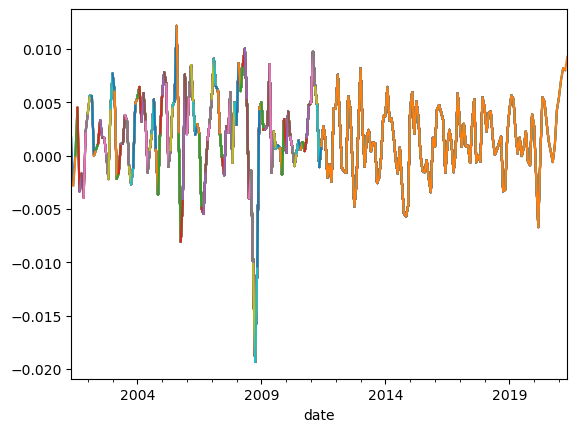

In [ ]:
#Initialize the wrapper object
model = wp.Model(df)
model.scaler = "Standard"
model.set_maxlag(6)
model.set_profile("all_features")
model.auto_print = False

model.window = 144 #12 years
model.set_modeltype("lassocv")
model.backtest_fixed_window_with_refit()
model.set_modeltype("elasticnetcv")
model.backtest_fixed_window_with_refit()

model.window = 180 #15 years
model.set_modeltype("lassocv")
model.backtest_fixed_window_with_refit()
model.set_modeltype("elasticnetcv")
model.backtest_fixed_window_with_refit()

model.window = 240 #20 years
model.set_modeltype("lassocv")
model.backtest_fixed_window_with_refit()
model.set_modeltype("elasticnetcv")
model.backtest_fixed_window_with_refit()

In [13]:
from multi_model_test import EvaluationMultiModel
multi = EvaluationMultiModel(df=df,folder="lassocv_all_features_lag5_lead1_20250718_190325")
coef_df = multi.get_non_zero_coef_matrix()
# Drop columns with fewer than 5 non-NaN values
coef_df = coef_df.loc[:, coef_df.count() >= 5]
multi.plot_coef_heatmap(coef_df=coef_df)
multi.plot_average_rmse_over_time()

No RMSE data found — computing it now.


c:\Users\Léo\OneDrive - Université Paris-Dauphine\_SEMESTRES\M2 104\Thesis\Lab\4 Benchmarks\single_model_test.py:146: UserWarning:

Model has no non-zero coefficients. Returning zero predictions.

c:\Users\Léo\OneDrive - Université Paris-Dauphine\_SEMESTRES\M2 104\Thesis\Lab\4 Benchmarks\single_model_test.py:146: UserWarning:

Model has no non-zero coefficients. Returning zero predictions.



In [11]:
multi.plot_dm_pval_matrix()

Computing DM tests first...


c:\Users\Léo\OneDrive - Université Paris-Dauphine\_SEMESTRES\M2 104\Thesis\Lab\4 Benchmarks\single_model_test.py:146: UserWarning:

Model has no non-zero coefficients. Returning zero predictions.

c:\Users\Léo\OneDrive - Université Paris-Dauphine\_SEMESTRES\M2 104\Thesis\Lab\4 Benchmarks\single_model_test.py:146: UserWarning:

Model has no non-zero coefficients. Returning zero predictions.

c:\Users\Léo\OneDrive - Université Paris-Dauphine\_SEMESTRES\M2 104\Thesis\Lab\4 Benchmarks\multi_model_test.py:269: RuntimeWarning:

invalid value encountered in scalar divide

